In [121]:
from torch.utils.data import DataLoader
from dataset import MusDBDataset
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
import matplotlib.pyplot as plt
import torch

import torch.nn as nn

from transformers import GPT2Model, GPT2Config

In [120]:
configuration = GPT2Config(
            n_positions=2048, # set to sthg large advised
            n_embd=256,
            n_layer=12,
            n_head=8,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )

In [132]:
class GPT2_TimeSeries_Forecasting(nn.Module):
    def __init__(self, config, n_dims_in, n_dims_out):
        super().__init__()
        self.read_in = nn.Linear(n_dims_in, config.n_embd)
        self.gpt2 = GPT2Model(config)
        self.read_out = nn.Linear(config.n_embd, n_dims_out)
    
    def forward(self, x):
        embeds = self.read_in(x)
        output = self.gpt2(inputs_embeds=embeds).last_hidden_state
        prediction = self.read_out(output)
        return prediction

In [137]:
model = GPT2_TimeSeries_Forecasting(configuration, 1, 1)

In [138]:
model

GPT2_TimeSeries_Forecasting(
  (read_in): Linear(in_features=1, out_features=256, bias=True)
  (gpt2): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(2048, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (read_out): Linear(in_features=256, out_features=1, bias=True)
)

In [126]:
dataset = MusDBDataset('musdb18hq/train', 16000, 1, 30*1e-3)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

[PosixPath('musdb18hq/train/Grants - PunchDrunk')]


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [127]:
example = next(iter(dataloader))

In [128]:
example["mixture"].shape

torch.Size([2, 480, 3])

In [129]:
mixture = example["mixture"][:, :, :2].mean(axis=-1)

In [140]:
model(mixture.unsqueeze(-1)).shape

torch.Size([2, 480, 1])

In [83]:
torch.ones_like(mixture).shape

torch.Size([2, 480])

In [97]:
past_time_features = torch.arange(0, 480).repeat(2, 1).unsqueeze(-1)

In [96]:
past_time_features.shape

torch.Size([2, 480, 1])

In [85]:
past_time_features.shape

torch.Size([2, 480])

In [86]:
mixture.shape, past_time_features.shape, torch.ones_like(mixture).shape

(torch.Size([2, 480]), torch.Size([2, 480]), torch.Size([2, 480]))

In [117]:
model.generate(
    past_values=mixture,
    past_time_features=past_time_features,
    past_observed_mask=torch.ones_like(mixture),
    future_time_features=torch.arange(0, 480).repeat(2, 1).unsqueeze(-1),
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (960x4 and 3x64)

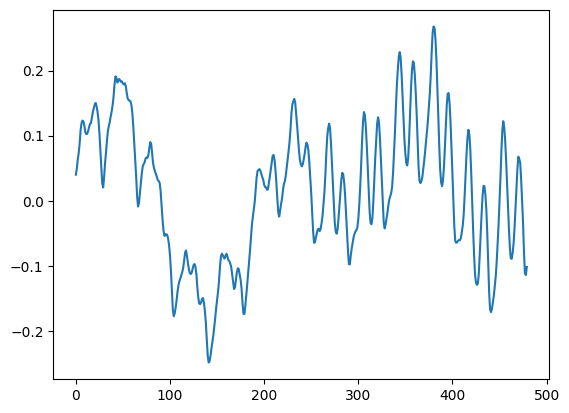

In [39]:
plt.plot(mixture[1])